In [1]:
!python --version

Python 3.12.11


In [2]:
# Install dependencies
!pip install -q --upgrade numerapi pandas pyarrow matplotlib lightgbm scikit-learn scipy cloudpickle==3.1.1
!pip install -q --no-deps numerai-tools


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [1]:
from numerapi import NumerAPI
import pandas as pd
import lightgbm as lgb

napi = NumerAPI()

# use one of the latest data versions
DATA_VERSION = "crypto/v2.0"

# Download and read training data
napi.download_dataset(f"{DATA_VERSION}/train.parquet")
data = pd.read_parquet(f"{DATA_VERSION}/train.parquet")

# split data into train / val at a ~70/30 ratio
split = int(len(data) * 0.7)
train = data[:split].copy()
val = data[split:].copy()

2025-10-08 10:50:06,923 INFO numerapi.utils: starting download
crypto/v2.0/train.parquet: 3.83MB [00:00, 13.9MB/s]                            


In [ ]:

train

,date,feature_bollinger_20d,feature_bollinger_60d,feature_close_avg_20d,feature_close_avg_60d,feature_close_ewa_20d,feature_close_ewa_60d,feature_market_cap_avg_20d,feature_market_cap_avg_60d,feature_market_cap_ewa_20d,...,feature_sharpe_ratio_20d,feature_sharpe_ratio_60d,feature_volatility_20d,feature_volatility_60d,feature_volume_avg_20d,feature_volume_avg_60d,feature_volume_ewa_20d,feature_volume_ewa_60d,target_binned_return_20,target_binned_return_60
symbol,,,,,,,,,,,,,,,,,,,,,
BTC,2020-01-01,0.50,0.50,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,0.50,0.50,0.00,0.00,1.00,1.00,1.00,1.00,0.50,0.50
LTC,2020-01-01,0.75,0.50,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,0.50,0.25,0.25,0.25,1.00,1.00,1.00,1.00,0.75,0.50
XRP,2020-01-01,0.50,0.50,0.50,0.50,0.50,0.50,1.00,1.00,1.00,...,0.50,0.25,0.25,0.00,1.00,1.00,1.00,1.00,0.50,0.50
DOGE,2020-01-01,0.25,0.25,0.25,0.25,0.25,0.25,0.75,0.75,0.75,...,0.50,0.50,0.00,0.00,0.75,0.75,0.75,0.75,0.50,0.50
VTC,2020-01-01,0.25,0.25,0.50,0.50,0.50,0.50,0.50,0.50,0.50,...,0.25,0.50,0.50,0.75,0.25,0.25,0.25,0.25,1.00,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FIL,2024-01-02,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,...,0.75,0.50,0.75,0.50,0.75,0.75,0.75,0.75,0.25,0.50
ELF,2024-01-02,0.25,0.25,0.50,0.50,0.50,0.50,0.50,0.50,0.50,...,0.25,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.75,0.50
WAXP,2024-01-02,0.50,0.50,0.25,0.25,0.25,0.25,0.50,0.50,0.50,...,0.50,0.25,0.25,0.50,0.50,0.50,0.50,0.50,0.50,0.50


In [2]:
# Train model
model = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=5,
    num_leaves=2**5-1,
    colsample_bytree=0.1
)
# We've found the following "deep" parameters perform much better,
#   but they require much more CPU and RAM
# model = lgb.LGBMRegressor(
#     n_estimators=30_000,
#     learning_rate=0.001,
#     max_depth=10,
#     num_leaves=2**10,
#     colsample_bytree=0.1,
#     min_data_in_leaf=10000,
# )
model.fit(
    train.filter(like="feature_"),
    train["target_binned_return_20"]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 112
[LightGBM] [Info] Number of data points in the train set: 307157, number of used features: 22
[LightGBM] [Info] Start training from score 0.499976
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,5
,learning_rate,0.01
,n_estimators,2000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


/var/folders/vm/jlf_h6td3b5dh_kg5p3xr45c0000gq/T/ipykernel_91204/2873597676.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ].groupby("date").apply(


<Axes: title={'center': 'Cumulative 20D Numerai Corr over Validation'}, xlabel='date'>

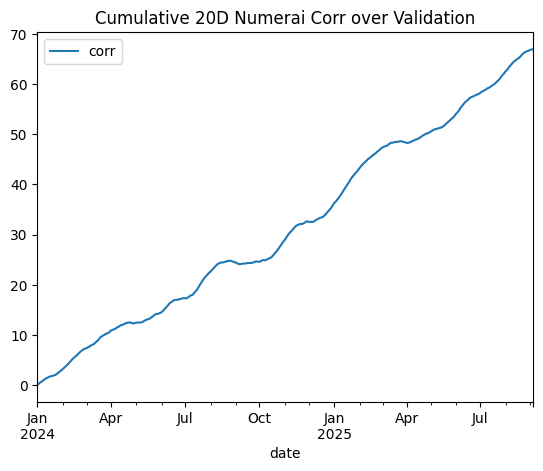

In [20]:
from numerai_tools.scoring import numerai_corr

val["prediction"] = model.predict(val.filter(like="feature_"))
validation_corr = val[
    ["date", "prediction", "target_binned_return_20"]
].groupby("date").apply(
    lambda df: numerai_corr(df[["prediction"]], df["target_binned_return_20"])
).rename(columns={"prediction": "corr"})
validation_corr.cumsum().plot(
    title="Cumulative 20D Numerai Corr over Validation"
)

In [ ]:
# download and read live data
napi.download_dataset(f"{DATA_VERSION}/live.parquet")
live_data = pd.read_parquet(f"{DATA_VERSION}/live.parquet")

# generate live predictions
live_data["prediction"] = model.predict(live_data.filter(like="feature_"))
submission = live_data.reset_index()[['symbol', 'prediction']]
submission

crypto/v2.0_beta/live.parquet: 21.5kB [00:00, 11.0MB/s]                   


In [ ]:
# Save and download your predictions
filename = f'crypto_example_preds.csv'
from numerai_tools.scoring import tie_kept_rank
submission[['prediction']] = tie_kept_rank(submission[['prediction']])
submission.to_csv(filename, index=False)

# Download file if running in Google Colab
try:
    from google.colab import files
    files.download(filename)
except:
    pass